
# Araç Fiyat Tahmini  


In [34]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.rcParams["figure.figsize"] = (7,4)



## 1. Çıktı Klasör Yapısı

Her önemli adımın sonunda veri CSV olarak kaydedilir.


In [35]:

OUT_DIR = Path("out")
OUT_DIR.mkdir(exist_ok=True)

def save_step(df, name):
    df.to_csv(OUT_DIR / f"{name}.csv", index=False)



## 2. Veri Yükleme

İlk olarak ham veri yüklenir ve genel yapısı incelenir.


In [36]:

df = pd.read_csv("toplu.csv")
df.shape


(1905, 20)

In [37]:

df.head()


,Fiyat,İlan Tarihi,Marka,Seri,Model,Yıl,Kilometre,Vites Tipi,Yakıt Tipi,Kasa Tipi,Renk,Motor Hacmi,Motor Gücü,Çekiş,Araç Durumu,Ort. Yakıt Tüketimi,Yakıt Deposu,Boya-değişen,Takasa Uygun,Kimden
0,870.000 TL,09 Aralık 2025,Hyundai,Accent Blue,1.6 CRDI Mode Plus,2018.0,210.000 km,Düz,Dizel,Sedan,Beyaz,1582 cc,136 hp,Önden Çekiş,İkinci El,"4,5 lt",43 lt,Tamamı orjinal,Takasa Uygun,Galeriden
1,725.000 TL,10 Aralık 2025,Fiat,Egea,1.4 Fire Urban,2016.0,147.000 km,Düz,LPG & Benzin,Sedan,Beyaz,1368 cc,95 hp,Önden Çekiş,İkinci El,"5,7 lt",45 lt,Tamamı orjinal,NaN,Sahibinden
2,1.235.000 TL,04 Aralık 2025,Volkswagen,Golf,1.6 TDi BlueMotion Comfortline,2014.0,118.000 km,Yarı Otomatik,Dizel,Hatchback/5,Beyaz,1598 cc,105 hp,Önden Çekiş,İkinci El,"3,9 lt",50 lt,"1 değişen, 2 boyalı",Takasa Uygun,Galeriden
3,695.000 TL,06 Aralık 2025,Toyota,Corolla,1.4 D-4D Advance,2015.0,305.000 km,Yarı Otomatik,Dizel,Sedan,Beyaz,1364 cc,90 hp,Önden Çekiş,İkinci El,"4,1 lt",55 lt,Belirtilmemiş,Takasa Uygun,Galeriden
4,590.000 TL,09 Aralık 2025,Opel,Astra,1.6 Enjoy,2003.0,159.750 km,Otomatik,LPG & Benzin,Hatchback/5,Gri (metalik),1598 cc,100 hp,Önden Çekiş,İkinci El,"7,7 lt",52 lt,1 boyalı,NaN,Sahibinden


In [38]:

save_step(df, "01_raw_data")



## 3. Tüm Sütunlara Genel Bakış


In [39]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905 entries, 0 to 1904
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fiyat                1904 non-null   object 
 1   İlan Tarihi          1904 non-null   object 
 2   Marka                1904 non-null   object 
 3   Seri                 1904 non-null   object 
 4   Model                1899 non-null   object 
 5   Yıl                  1904 non-null   float64
 6   Kilometre            1904 non-null   object 
 7   Vites Tipi           1904 non-null   object 
 8   Yakıt Tipi           1904 non-null   object 
 9   Kasa Tipi            1904 non-null   object 
 10  Renk                 1904 non-null   object 
 11  Motor Hacmi          1872 non-null   object 
 12  Motor Gücü           1880 non-null   object 
 13  Çekiş                1883 non-null   object 
 14  Araç Durumu          1904 non-null   object 
 15  Ort. Yakıt Tüketimi  1450 non-null   o

In [40]:

df.isna().mean().sort_values(ascending=False)


Takasa Uygun           0.286614
Ort. Yakıt Tüketimi    0.238845
Yakıt Deposu           0.194751
Motor Hacmi            0.017323
Motor Gücü             0.013123
Çekiş                  0.011549
Model                  0.003150
Fiyat                  0.000525
Seri                   0.000525
Marka                  0.000525
İlan Tarihi            0.000525
Kilometre              0.000525
Renk                   0.000525
Kasa Tipi              0.000525
Yakıt Tipi             0.000525
Vites Tipi             0.000525
Yıl                    0.000525
Araç Durumu            0.000525
Boya-değişen           0.000525
Kimden                 0.000525
dtype: float64

In [41]:

save_step(df, "02_global_overview")



## 4. Hedef Değişken: Fiyat

Modelin öğrenmeye çalışacağı değişken Fiyat olduğu için
önce bu sütun detaylı şekilde incelenir.



In [42]:

df["Fiyat"].describe()


count           1904
unique           693
top       350.000 TL
freq              14
Name: Fiyat, dtype: object

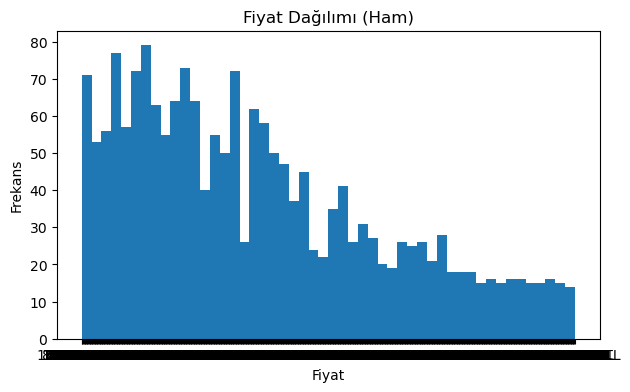

In [43]:

plt.hist(df["Fiyat"].dropna(), bins=50)
plt.title("Fiyat Dağılımı (Ham)")
plt.xlabel("Fiyat")
plt.ylabel("Frekans")
plt.show()



Gözlem:  
Fiyat sütunu metinsel ifadeler ve aşırı uç değerler içermektedir.
Bu nedenle temizleme yapılması gerekmektedir.


In [44]:

def clean_price(val):
    if pd.isna(val):
        return np.nan
    val = str(val).replace("TL", "").replace(".", "").strip()
    if val == "":
        return np.nan
    try:
        return float(val)
    except:
        return np.nan

df["Fiyat"] = df["Fiyat"].apply(clean_price)
df = df.dropna(subset=["Fiyat"])


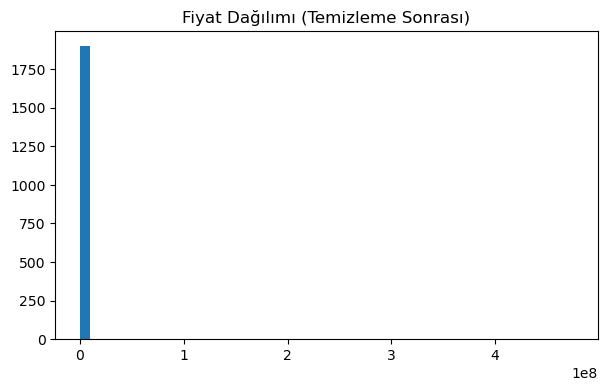

In [45]:

plt.hist(df["Fiyat"], bins=50)
plt.title("Fiyat Dağılımı (Temizleme Sonrası)")
plt.show()


In [46]:

save_step(df, "03_price_cleaned")



## 5. Fiyat Aykırı Değer Analizi

Araç fiyatlarında çok düşük veya çok yüksek değerler
genellikle hatalı ilanlardan kaynaklanır.

Bu nedenle %1–%99 aralığı dışında kalan değerler çıkarılacak.


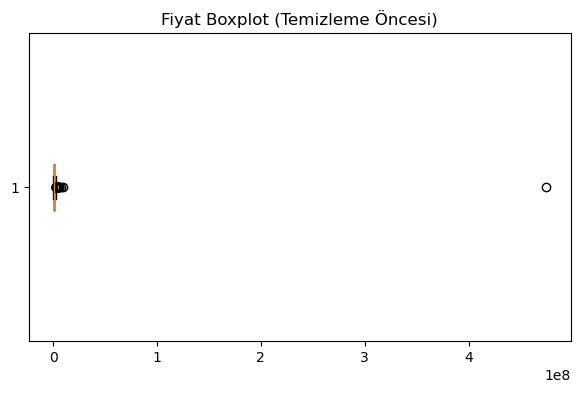

In [47]:

low = df["Fiyat"].quantile(0.01)
high = df["Fiyat"].quantile(0.99)

plt.boxplot(df["Fiyat"], vert=False)
plt.title("Fiyat Boxplot (Temizleme Öncesi)")
plt.show()

df = df[(df["Fiyat"] > low) & (df["Fiyat"] < high)]


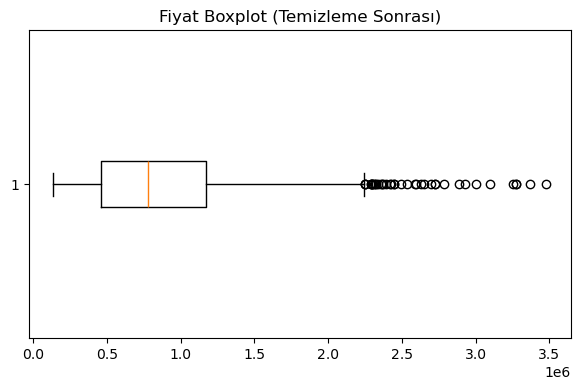

In [48]:

plt.boxplot(df["Fiyat"], vert=False)
plt.title("Fiyat Boxplot (Temizleme Sonrası)")
plt.show()


In [49]:

save_step(df, "04_price_outliers_removed")



## 6. Kilometre Sütunu İncelemesi



In [50]:

df["Kilometre"].describe()


count           1862
unique           657
top       250.000 km
freq              24
Name: Kilometre, dtype: object

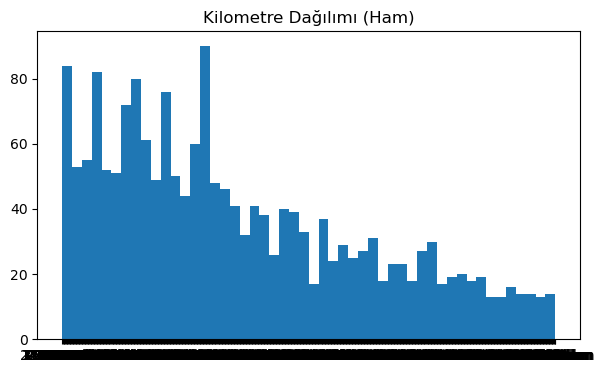

In [51]:

plt.hist(df["Kilometre"].dropna(), bins=50)
plt.title("Kilometre Dağılımı (Ham)")
plt.show()


In [52]:

def clean_km(val):
    if pd.isna(val):
        return np.nan
    val = str(val).replace("km", "").replace(".", "").strip()
    try:
        return float(val)
    except:
        return np.nan

df["Kilometre"] = df["Kilometre"].apply(clean_km)


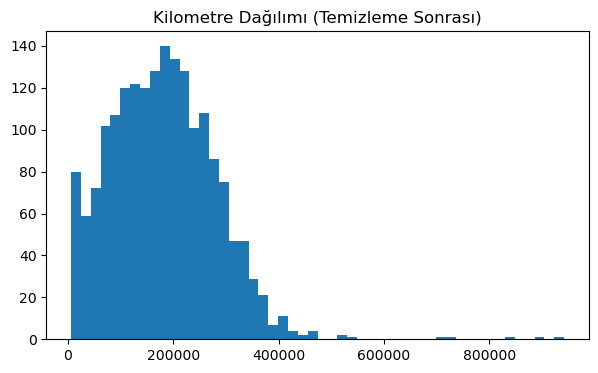

In [53]:

plt.hist(df["Kilometre"].dropna(), bins=50)
plt.title("Kilometre Dağılımı (Temizleme Sonrası)")
plt.show()


In [54]:

save_step(df, "05_kilometre_cleaned")



## 7. Motor Hacmi ve Motor Gücü

Motor bilgileri metinsel ve aralıklı ifadeler içerebildiği için
sayısal hale getirilmiştir.


In [55]:

def clean_engine(val):
    if pd.isna(val):
        return np.nan
    val = str(val).lower().replace("cc", "").replace("hp", "").replace("cm3", "").replace(".", "").strip()
    if "-" in val:
        try:
            a, b = val.split("-")
            return (float(a) + float(b)) / 2
        except:
            return np.nan
    try:
        return float(val)
    except:
        return np.nan

df["Motor Hacmi"] = df["Motor Hacmi"].apply(clean_engine)
df["Motor Gücü"] = df["Motor Gücü"].apply(clean_engine)


In [56]:

save_step(df, "06_engine_cleaned")



## 8. Feature Engineering

- Araç yaşı hesaplanmıştır  
- Hasar durumu sayısal hale getirilmiştir


In [57]:

def hasar_durumu_analiz(text):
    text = str(text).lower()
    if "orjinal" in text or "hatasız" in text:
        return 0
    elif "belirtilmemiş" in text:
        return 2
    else:
        return 1

df["Hasar_Durumu"] = df["Boya-değişen"].apply(hasar_durumu_analiz)
df["Yas"] = 2025 - df["Yıl"]


In [58]:

save_step(df, "07_feature_engineering")



## 9. Eksik Değerler

Sayısal alanlarda median kullanılmıştır.
Bu yöntem aykırı değerlere karşı daha dayanıklıdır.


In [59]:

num_cols = ["Yas", "Kilometre", "Motor Hacmi", "Motor Gücü"]
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())


In [60]:

save_step(df, "08_missing_filled")


In [61]:

cat_cols = ["Marka","Seri","Model","Vites Tipi","Yakıt Tipi","Kasa Tipi","Renk","Çekiş"]

for col in cat_cols:
    print(col, df[col].nunique())


Marka 36
Seri 179
Model 777
Vites Tipi 3
Yakıt Tipi 5
Kasa Tipi 9
Renk 23
Çekiş 4


In [62]:

label_encoders = {}
for col in cat_cols:
    df[col] = df[col].fillna("Bilinmiyor")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


In [63]:

save_step(df, "09_encoded")



## 11. Modelleme ve Karşılaştırma

Farklı model türleri denenerek
en iyi genelleyen model seçilmiştir.


In [64]:

X = df.drop(["Fiyat","İlan Tarihi","Yakıt Deposu","Ort. Yakıt Tüketimi",
             "Boya-değişen","Takasa Uygun","Kimden","Araç Durumu","Yıl"],
            axis=1, errors="ignore")
y = df["Fiyat"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [65]:

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42
    )
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append({
        "Model": name,
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds)
    })

pd.DataFrame(results).sort_values("R2", ascending=False)


,Model,R2,MAE
2,GradientBoosting,0.923470,94259.436975
1,RandomForest,0.903007,105056.874298
0,LinearRegression,0.770681,179164.866579


# 12. Modelin Kaydedilmesi

Karşılaştırma sonucunda en yüksek R² skoruna sahip model,
nihai model olarak seçilmiş ve kaydedilmiştir.



In [66]:
import joblib

best_model_name = max(results, key=lambda x: x["R2"])["Model"]
best_model = models[best_model_name]

print("Seçilen Model:", best_model_name)

MODEL_PATH = OUT_DIR / "best_model.joblib"
joblib.dump(best_model, MODEL_PATH)

print("Model kaydedildi ->", MODEL_PATH)


Seçilen Model: GradientBoosting
Model kaydedildi -> out\best_model.joblib
